**running time = 115 min** Intel i5-2450M 2500MHz / 4096Mb Memory / AMD Radeon HD 7600M

Файл evo_train.csv содержит название товара и id группы, categories.csv сопоставляет каждому id название группы.

Проблема: некоторые товары неверно отнесены к группе. Построим модель для нахождения ошибок.

Например: "масло 180 г азова"	- "Алкоголь", должно быть "Продукты питания"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.stem.snowball import RussianStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import string
from sklearn.metrics import log_loss
import time
RANDOM_STATE = 51

In [2]:
data0 = pd.read_csv('evo_train.csv', delimiter=',',low_memory=False)
cat = pd.read_csv('categories.csv', delimiter=',',low_memory=False)
columns = cat.columns.values.copy()
columns[1] = 'GROUP_NAME'
cat.columns = columns

In [3]:
# print(data0.shape)
# display(data0.head())
# print(cat.shape)
# display(cat.head())

In [4]:
data = pd.merge(data0, cat, on='GROUP_ID')
data = data.drop('PATH',axis=1)
data = data.sort_values(by=['id'])
data.index = data.id
print(data.shape)
display(data[:10])

(55860, 4)


,NAME,GROUP_ID,id,GROUP_NAME
id,,,,
0,"Пиво ""Жигулевское"" 0,5 л. св.",35,0,"Пиво, слабоалкогольные напитки"
1,СОУС ТОМАТНЫЙ БУЗДЯК 670Г ТАТАРСКИЙ /8,6,1,Продукты питания
2,Сигареты Esse SS Exchange,7,2,Табачные изделия
3,Петрушка,6,3,Продукты питания
4,пиво ягерь,35,4,"Пиво, слабоалкогольные напитки"
5,"Детский мармелад ""Trolls"" Черничка Лакомства д...",6,5,Продукты питания
6,"ООО""Продукты-24часа"" ведение бух. учета за фев...",20,6,Бытовые услуги
7,кисточка для теней и хайлайтеров,14,7,"Косметика, гигиена и парфюмерия"
8,"Свеча Фонтан тортовой 12,5см/1 шт.",24,8,Хозтовары


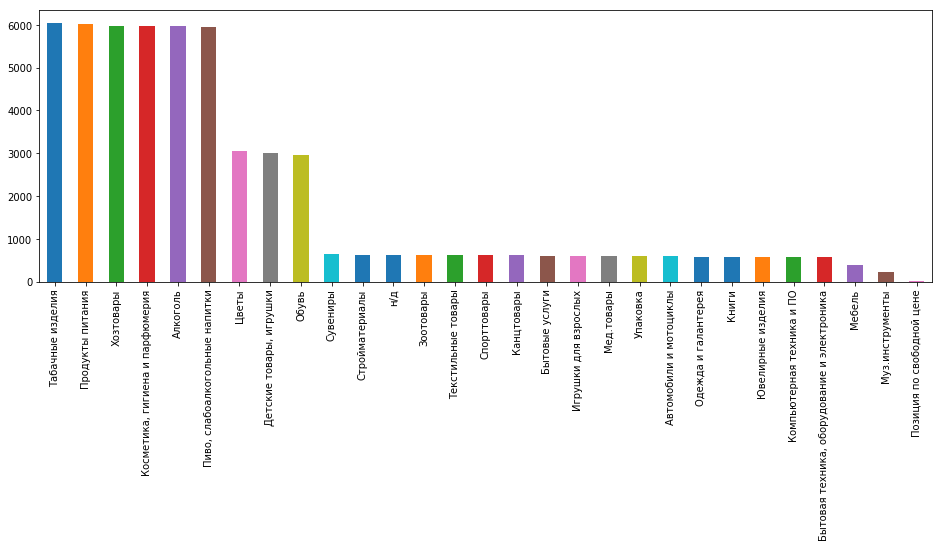

In [5]:
plt.figure(figsize=(16,5))
data['GROUP_NAME'].value_counts().plot(kind = 'bar')
# top [7,6,24,14,34,35]
# Выборка несбаланисрована по классам, поэтому будем использовать балансировку весами в регрессии

In [116]:
df = pd.DataFrame(data['GROUP_ID'].value_counts().reset_index())
df.columns = ['GROUP_ID','count']
df['percentage'] = df['count']/data.shape[0]

In [201]:
# Удаляем символы, отделяем цифры от букв
# stemmer = RussianStemmer() #лемматизация ухудшает скор

def process_text(text):
    text = text.lower().strip()
    text = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~«»]', ' ', text)
#     text = ' '.join(word for word in text.split() if len(word) > 1)
    text = ' '.join(word for word in re.split('(\d+)',text))
#     text = ' '.join(stemmer.stem(word) for word in text.split())
    
    return text

[process_text(text) for text in data['NAME'][:10]]

['пиво  жигулевское  0 5 л  св ',
 'соус томатный буздяк 670г татарский  8',
 'сигареты  esse ss exchange',
 'петрушка',
 'пиво ягерь',
 'детский мармелад  trolls  черничка лакомства для здоровья 105гр',
 'ооо продукты 24часа  ведение бух  учета за февраль',
 'кисточка для теней и хайлайтеров',
 'свеча фонтан тортовой 12 5см 1 шт ',
 'сумка sti  06ch  634  black']

In [198]:
%%time
data['NAME_PROC'] = data['NAME'].apply(process_text)

Wall time: 517 ms


In [8]:
data.head()

,NAME,GROUP_ID,id,GROUP_NAME,NAME_PROC
id,,,,,
0,"Пиво ""Жигулевское"" 0,5 л. св.",35,0,"Пиво, слабоалкогольные напитки",пив жигулевск 0 5 л св
1,СОУС ТОМАТНЫЙ БУЗДЯК 670Г ТАТАРСКИЙ /8,6,1,Продукты питания,соус томатн буздяк 670 г татарск 8
2,Сигареты Esse SS Exchange,7,2,Табачные изделия,сигарет ess ss exchang
3,Петрушка,6,3,Продукты питания,петрушк
4,пиво ягерь,35,4,"Пиво, слабоалкогольные напитки",пив ягер


In [9]:
def build_pipe_predict(vect,clf,X_train,y_train, X_test, y_test):
    start_time = time.time()
    pipeline = Pipeline([("vect", vect),
                         ("clf", clf)])
    pipeline.fit(X_train, y_train)
    predicted = pipeline.predict(X_test)
    acc = accuracy_score(y_test, predicted)
    lg_loss = log_loss(y_test, pipeline.predict_proba(X_test))
    run_time = round(time.time() - start_time)
    print('accuracy: {}, log_loss = {}, time = {} s'.format(acc,lg_loss,run_time))
    return predicted

In [199]:
# удаляем класс "позиция по свободной цене", данных мало
# Пробовал различные связки CountVectorizer, TfidfVectorizer, SGDClassifier, LogisticRegression
# Оставлена наилучшая пара
data_reduced = data[data['GROUP_ID']!=32]
X = data_reduced['NAME_PROC']
y = data_reduced['GROUP_ID']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vect = CountVectorizer(ngram_range=(3, 6), analyzer='char')
clf = LogisticRegression(class_weight='balanced', random_state=42)
build_pipe_predict(vect,clf,X_train,y_train, X_test, y_test)

accuracy: 0.9340196956132498, log_loss = 0.26860007517300183, time = 232 s


array([38,  7, 37, ..., 18, 24, 24], dtype=int64)

In [200]:
%%time
# здесь пробую различные варианты обработки текста
data_reduced = data[data['GROUP_ID']!=32]
X = data_reduced['NAME_PROC']
y = data_reduced['GROUP_ID']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

vect = CountVectorizer(ngram_range=(3, 6), analyzer='char')
clf = LogisticRegression(class_weight='balanced', random_state=42)
vectorized = vect.fit_transform(X_train)
pipeline = Pipeline([("vect", vect), ("clf", clf)])
pipeline.fit(X_train, y_train)
predicted = pipeline.predict(X_test)
acc = accuracy_score(y_test, predicted)
pred_proba = pipeline.predict_proba(X_test)
lg_loss = log_loss(y_test, pred_proba)
print('accuracy: {}, log_loss = {}. missed {}'.format(acc,lg_loss, np.sum([predicted!=y_test])))

accuracy: 0.9409237379162191, log_loss = 0.2471282234931253. missed 165
Wall time: 4min 55s


In [202]:
# Придерживаюсь такой логике: делим выборку на 20 частей, и проводим 20 экспериментов - делаем предсказания на 5% выборки.
# Строки для которых предсказание не соответсвует разметке заносим в df_all
data_reduced = data[data['GROUP_ID']!=32]
X = data_reduced['NAME_PROC']
y = data_reduced['GROUP_ID']
n_splits = 20
skf = StratifiedKFold(n_splits=n_splits)
df_all = pd.DataFrame(columns=['id', 'NAME', 'NAME_PROC', 'GROUP_ID', 'GROUP_NAME',
       'GROUP_ID_PRED', 'GROUP_NAME_PRED', 'proba'])

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    start_time = time.time()
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    
    vect = CountVectorizer(ngram_range=(3, 6), analyzer='char')
    clf = LogisticRegression(class_weight='balanced', random_state=42)
    vectorized = vect.fit_transform(X_train)
    pipeline = Pipeline([("vect", vect), ("clf", clf)])
    pipeline.fit(X_train, y_train)
    predicted = pipeline.predict(X_test)
    acc = round(accuracy_score(y_test, predicted),4)
    pred_proba = pipeline.predict_proba(X_test)
    lg_loss = round(log_loss(y_test, pred_proba),4)
    
    predicted_df = pd.DataFrame(predicted, columns=['GROUP_ID'])
    predicted_wrong = predicted_df.iloc[np.where([y_test!=predicted])[1]]
    predicted_wrong = predicted_wrong.reset_index()
    predicted_wrong = pd.merge(predicted_wrong, cat, on='GROUP_ID')
    predicted_wrong = predicted_wrong.sort_values(by=['index'])
    predicted_wrong = predicted_wrong.reset_index()
    predicted_wrong = predicted_wrong[['GROUP_ID','GROUP_NAME']]
    predicted_wrong.columns = ['GROUP_ID_PRED','GROUP_NAME_PRED']
    pred_proba_df = pd.DataFrame(pred_proba.max(axis=1), columns=['proba'])
    pred_proba_df = pred_proba_df.iloc[np.where([y_test!=predicted])[1]]
    pred_proba_df = pred_proba_df.reset_index().drop('index',axis=1)
    left = data.iloc[X_test[y_test!=predicted].index.values]
    left = left.drop('id',axis=1).reset_index()
    left = left[['id','NAME','NAME_PROC','GROUP_ID','GROUP_NAME']]
    df = pd.concat([left,predicted_wrong,pred_proba_df], axis=1)
    df_all = pd.concat([df_all, df])
    
    exec_time = round(time.time() - start_time)
    print('{}/{} accuracy: {}, log_loss: {}, mistakes {} of {}, exec_time {} s'.format(i, n_splits, acc,lg_loss, 
                           np.sum([predicted!=y_test]), y_test.shape[0], exec_time))

0/20 accuracy: 0.9401, log_loss: 0.2454, mistakes 168 of 2806, exec_time 333 s
1/20 accuracy: 0.9415, log_loss: 0.2343, mistakes 164 of 2805, exec_time 288 s
2/20 accuracy: 0.9373, log_loss: 0.2556, mistakes 176 of 2805, exec_time 278 s
3/20 accuracy: 0.9408, log_loss: 0.2257, mistakes 166 of 2803, exec_time 279 s
4/20 accuracy: 0.934, log_loss: 0.264, mistakes 185 of 2801, exec_time 278 s
5/20 accuracy: 0.9375, log_loss: 0.2611, mistakes 175 of 2800, exec_time 280 s
6/20 accuracy: 0.9353, log_loss: 0.2642, mistakes 181 of 2797, exec_time 279 s
7/20 accuracy: 0.9424, log_loss: 0.2447, mistakes 161 of 2795, exec_time 281 s
8/20 accuracy: 0.9409, log_loss: 0.2461, mistakes 165 of 2793, exec_time 280 s
9/20 accuracy: 0.9277, log_loss: 0.2978, mistakes 202 of 2793, exec_time 281 s
10/20 accuracy: 0.9287, log_loss: 0.2798, mistakes 199 of 2792, exec_time 281 s
11/20 accuracy: 0.9388, log_loss: 0.2374, mistakes 171 of 2792, exec_time 282 s
12/20 accuracy: 0.9459, log_loss: 0.2254, mistakes 1

In [203]:
df_all.to_csv('df_all_1.csv')

In [204]:
# Чем больше значение в столбце proba, тем более мы уверены в том что разметка неверна.
# значение proba- это максимальная вероятность из всех вероятностей pipeline.predict_proba
# df_sorted = df_all.sort_values(by=['proba'])
# df_sorted.reset_index().iloc[-100:]

df_all_tresh_80 = df_all[df_all['proba']>0.8]
# Итоговая таблица с порогом 0.8 GROUP_ID_PRED	GROUP_NAME_PRED предсказанные значения для категорий
df_all_tresh_80.head(20)

,id,NAME,NAME_PROC,GROUP_ID,GROUP_NAME,GROUP_ID_PRED,GROUP_NAME_PRED,proba
0,12,Масло 180г Азова,масло 180 г азова,34,Алкоголь,6,Продукты питания,0.885306
6,81,Напульсники красные,напульсники красные,59,Игрушки для взрослых,18,Спорттовары,0.822965
8,125,ликер Витторио Морелло,ликер витторио морелло,35,"Пиво, слабоалкогольные напитки",34,Алкоголь,0.949921
10,141,8875 вызов специалиста,8875 вызов специалиста,26,"Детские товары, игрушки",6,Продукты питания,0.866143
11,165,Маточное молочко адсорбированное в с/б 0.008 кг,маточное молочко адсорбированное в с б 0 0...,14,"Косметика, гигиена и парфюмерия",6,Продукты питания,0.893929
29,473,КОНТЕКС ГЕЛЬ-СМАЗКА GREEN 30МЛ,контекс гель смазка green 30 мл,27,Мед.товары,59,Игрушки для взрослых,0.941875
31,503,Ворота гаражные секционные DoorHan (RSD02),ворота гаражные секционные doorhan rsd 02,22,Автомобили и мотоциклы,6,Продукты питания,0.863088
41,743,ШАР ВОЗДУШНЫЙ ФИГУРА/V70 STREET ДРАКОША 1ШТ (Ф...,шар воздушный фигура v 70 street дракоша 1 ш...,29,Сувениры,26,"Детские товары, игрушки",0.954857
43,757,За октябрь.Возмещение затрат по сбросу загрязн...,за октябрь возмещение затрат по сбросу загрязн...,6,Продукты питания,20,Бытовые услуги,0.936591
46,836,Туалетная вода Cotton Beige,туалетная вода cotton beige,24,Хозтовары,14,"Косметика, гигиена и парфюмерия",0.865094


In [205]:
# Часто ошибаемся в выборе между алкоголем и слабоалкогольными напитками, попробуем уточнить результат
df_alc = df_all[(df_all['GROUP_ID']==35) & (df_all['GROUP_ID_PRED']==34) |
                (df_all['GROUP_ID']==34) & (df_all['GROUP_ID_PRED']==35)]
alc_idxs = df_alc[df_alc.proba>0.5]['id'] #idшники таких товаров, отфильтровываем неуверренные порогом 0.5
alc_idxs.shape

(42,)

In [206]:
data_alc = data[data['GROUP_ID'].isin([34,35])]
# здесь все товары с GROUP_ID 34 или 35 за вычетом неправильно определенных в предыдущем эксперименте
# Обучимся только на этих двух категориях и сделаем предсказания на alc_idxs
data_alc = data_alc.iloc[~data_alc.index.isin(alc_idxs)] 
skf = StratifiedKFold(n_splits=n_splits)

start_time = time.time()
X_train = data_alc['NAME_PROC']
y_train = data_alc['GROUP_ID']
X_test = data.iloc[alc_idxs]['NAME_PROC']
y_test = data.iloc[alc_idxs]['GROUP_ID']

vect = CountVectorizer(ngram_range=(3, 6), analyzer='char')
clf = LogisticRegression(class_weight='balanced', random_state=42)
vectorized = vect.fit_transform(X_train)
pipeline = Pipeline([("vect", vect), ("clf", clf)])
pipeline.fit(X_train, y_train)
predicted = pipeline.predict(X_test)
acc = round(accuracy_score(y_test, predicted),4)
pred_proba = pipeline.predict_proba(X_test)
lg_loss = round(log_loss(y_test, pred_proba),4)

predicted_df = pd.DataFrame(predicted, columns=['GROUP_ID'])
predicted_wrong = predicted_df.iloc[np.where([y_test!=predicted])[1]]
predicted_wrong = predicted_wrong.reset_index()
predicted_wrong = pd.merge(predicted_wrong, cat, on='GROUP_ID')
predicted_wrong = predicted_wrong.sort_values(by=['index'])
predicted_wrong = predicted_wrong.reset_index()
predicted_wrong = predicted_wrong[['GROUP_ID','GROUP_NAME']]
predicted_wrong.columns = ['GROUP_ID_PRED','GROUP_NAME_PRED']
pred_proba_df = pd.DataFrame(pred_proba.max(axis=1), columns=['proba'])
pred_proba_df = pred_proba_df.iloc[np.where([y_test!=predicted])[1]]
pred_proba_df = pred_proba_df.reset_index().drop('index',axis=1)
left = data.iloc[X_test[y_test!=predicted].index.values]
left = left.drop('id',axis=1).reset_index()
left = left[['id','NAME','NAME_PROC','GROUP_ID','GROUP_NAME']]
df_all_alc = pd.concat([left,predicted_wrong,pred_proba_df], axis=1)

exec_time = round(time.time() - start_time)
print('accuracy: {}, log_loss: {}, mistakes {} of {}, exec_time {} s'.format(acc,lg_loss, 
                       np.sum([predicted!=y_test]), y_test.shape[0], exec_time))

accuracy: 0.1905, log_loss: 3.2181, mistakes 34 of 42, exec_time 7 s


In [207]:
df_all_alc
# Плохо работает, думаю проблема в том что по названию алкоголя сложно корректно определить крепкость 
# например СИДР БЛЕЙЗЕР вроде бы и сидр но крепкий

,id,NAME,NAME_PROC,GROUP_ID,GROUP_NAME,GROUP_ID_PRED,GROUP_NAME_PRED,proba
0,125,ликер Витторио Морелло,ликер витторио морелло,35,"Пиво, слабоалкогольные напитки",34,Алкоголь,0.984648
1,3229,1488 Премиум виски бир,1488 премиум виски бир,35,"Пиво, слабоалкогольные напитки",34,Алкоголь,0.933476
2,5756,сидр фруктовый Блейзер джин тоник,сидр фруктовый блейзер джин тоник,34,Алкоголь,35,"Пиво, слабоалкогольные напитки",0.973787
3,6345,НАПИТОК СЛ/АЛКОГОЛЬНЫЙ ДЖИН-ТОНИК 9% 1Л ОЧАКОВ...,напиток сл алкогольный джин тоник 9 1 л оч...,35,"Пиво, слабоалкогольные напитки",34,Алкоголь,0.978164
4,8512,"БЕЛАЯ СКАЛА КРЫМ 0,5Л",белая скала крым 0 5 л,35,"Пиво, слабоалкогольные напитки",34,Алкоголь,0.686671
5,9503,Белое Пенное пшеничное,белое пенное пшеничное,34,Алкоголь,35,"Пиво, слабоалкогольные напитки",0.540594
6,10199,011 Белофф Кузнецк,011 белофф кузнецк,35,"Пиво, слабоалкогольные напитки",34,Алкоголь,0.857265
7,14200,вино Ля Круа Каберне Совиньон,вино ля круа каберне совиньон,35,"Пиво, слабоалкогольные напитки",34,Алкоголь,0.999580
8,15462,Сидр Блейзер со вкусом белого винограда,сидр блейзер со вкусом белого винограда,34,Алкоголь,35,"Пиво, слабоалкогольные напитки",0.981803
9,16422,"НАПИТОК ПИВНОЙ ""RAZOR"" МАХИТО ДРАЙВ 1,5Л. АЛК....",напиток пивной razor махито драйв 1 5 л ...,34,Алкоголь,35,"Пиво, слабоалкогольные напитки",0.998790
